In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

1. Разделите данные Титаника (train.csv) на тренировочную, валидационную и тестовую часть. С помощью валидационной части подберите гиперпараметры для моделей Random Forest, XGBoost, Logistic Regression и KNN. Получите точность этих моделей на тестовой части.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [3]:
df_main = pd.read_csv('data/titanic/train.csv')
df_main.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def prepare_num(df):
    df_num = df.drop(['Sex', 'Embarked', 'Pclass'], axis=1)
    df_sex = pd.get_dummies(df['Sex'])
    df_emb = pd.get_dummies(df['Embarked'], prefix='Emb')
    df_pcl = pd.get_dummies(df['Pclass'], prefix='Pclass')

    df_num = pd.concat((df_num, df_sex, df_emb, df_pcl), axis=1)
    return df_num

In [5]:
def split_data(X_scaled, y):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    return X_train, X_val, X_test, y_train, y_val, y_test


def scale_data(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

In [6]:
y = df_main['Survived']
X = df_main.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
X_prepared = prepare_num(X)
X_prepared = X_prepared.fillna(X_prepared.median())
X_scaled = scale_data(X_prepared)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_scaled, y)

,Age,SibSp,Parch,Fare,female,male,Emb_C,Emb_Q,Emb_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,0,1,0,0,1,0,1,0
887,19.0,0,0,30.0000,1,0,0,0,1,1,0,0
888,28.0,1,2,23.4500,1,0,0,0,1,0,0,1
889,26.0,0,0,30.0000,0,1,1,0,0,1,0,0


In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
def get_accuracy(model, X_test, y_test):
    predict = model.predict(X_test)
    return accuracy_score(y_test, predict)

XGBoost

In [9]:
from xgboost import XGBClassifier

In [10]:
def xgb(X_train, X_val, y_train, y_val):
    clf = XGBClassifier()
    parameters = {
        'max_depth': range(2, 10, 1),
        'n_estimators': range(60, 220, 40),
        'learning_rate': [0.1, 0.01, 0.05]
    }
    grid = GridSearchCV(clf, parameters, cv=5)
    grid.fit(X_train, y_train)
    max_depth = grid.best_params_.get('max_depth')
    n_estimators = grid.best_params_.get('n_estimators')
    learning_rate = grid.best_params_.get('learning_rate')
    model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                          learning_rate=learning_rate)
    model.fit(X_train, y_train)
    predict = model.predict(X_val)
    acc = accuracy_score(y_val, predict)
    print(f'Лучшие параметры:\n{grid.best_params_}')
    print('Лучшая accuracy на валидации: {:.2%}'.format(acc))
    return model

In [11]:
model = xgb(X_train, X_val, y_train, y_val)
acc = get_accuracy(model, X_test, y_test)
print('Accuracy на тесте: {:.2%}'.format(acc))

Лучшие параметры:
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 180}
Лучшая accuracy на валидации: 79.72%
Accuracy на тесте: 79.89%


Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
def logistic_regression(X_train, X_val, y_train, y_val):
    clf = LogisticRegression()
    parameters = {
        'C': np.arange(0.01, 1, 0.01),
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    }
    grid = GridSearchCV(clf, parameters, cv=5)
    grid.fit(X_train, y_train)
    C = grid.best_params_.get('C')
    solver = grid.best_params_.get('solver')
    model = LogisticRegression(C=C, solver=solver)
    model.fit(X_train, y_train)
    predict = model.predict(X_val)
    acc = accuracy_score(y_val, predict)
    print(f'Лучшие параметры:\n{grid.best_params_}')
    print('Лучшая accuracy на валидации: {:.2%}'.format(acc))
    return model

In [14]:
model = logistic_regression(X_train, X_val, y_train, y_val)
acc = get_accuracy(model, X_test, y_test)
print('Accuracy на тесте: {:.2%}'.format(acc))

Лучшие параметры:
{'C': 0.02, 'solver': 'lbfgs'}
Лучшая accuracy на валидации: 80.42%
Accuracy на тесте: 77.09%


KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
def KNN(X_train, X_val, y_train, y_val):
    clf = KNeighborsClassifier()
    parameters = {
        'n_neighbors': range(1, 31)
    }
    grid = GridSearchCV(clf, parameters, cv=5)
    grid.fit(X_train, y_train)
    n_neighbors = grid.best_params_.get('n_neighbors')
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    predict = model.predict(X_val)
    acc = accuracy_score(y_val, predict)
    print(f'Лучшие параметры:\n{grid.best_params_}')
    print('Лучшая accuracy на валидации: {:.2%}'.format(acc))
    return model

In [17]:
model = KNN(X_train, X_val, y_train, y_val)
acc = get_accuracy(model, X_test, y_test)
print('Accuracy на тесте: {:.2%}'.format(acc))

Лучшие параметры:
{'n_neighbors': 4}
Лучшая accuracy на валидации: 80.42%
Accuracy на тесте: 78.21%


RandomForest

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
def random_forest(X_train, X_val, y_train, y_val):
    clf = RandomForestClassifier()
    parameters = {
        'n_estimators': range(10, 30, 10),
        'max_depth': range(1, 13, 2),
        'min_samples_leaf': range(1, 8),
        'min_samples_split': range(2, 10, 2),
        'criterion': ['gini', 'entropy', 'log_loss']
    }
    grid = GridSearchCV(clf, parameters, cv=5)
    grid.fit(X_train, y_train)
    max_depth = grid.best_params_.get('max_depth')
    min_samples_leaf = grid.best_params_.get('min_samples_leaf')
    min_samples_split = grid.best_params_.get('min_samples_split')
    n_estimators = grid.best_params_.get('n_estimators')
    criterion = grid.best_params_.get('criterion')
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    predict = model.predict(X_val)
    acc = accuracy_score(y_val, predict)
    print(f'Лучшие параметры:\n{grid.best_params_}')
    print('Лучшая accuracy: {:.2%}'.format(acc))
    return model

In [20]:
model = random_forest(X_train, X_val, y_train, y_val)
acc = get_accuracy(model, X_test, y_test)
print('Accuracy: {:.2%}'.format(acc))

Лучшие параметры:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 20}
Лучшая accuracy: 81.82%
Accuracy: 79.33%


2. С помощью RandomForest выберите 2, 4, 8 самых важных признаков и проверьте точность моделей только на этих признаках.

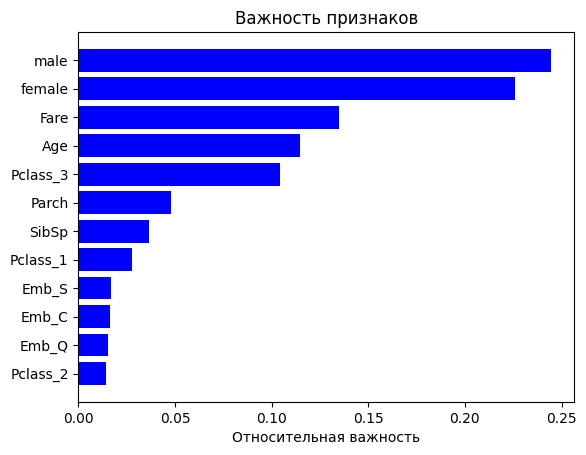

In [21]:
importances = model.feature_importances_
features = X_prepared.columns

# Добавление сортировки по важности
indices = np.argsort(importances)

plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительная важность')
plt.show()

In [22]:
def test_n_features(model, X_prepared, y, n):
    X = X_prepared[features[indices][-n:]]
    X = scale_data(X)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    model.fit(X_train, y_train)
    return get_accuracy(model, X_test, y_test)

In [23]:
acc = test_n_features(model, X_prepared, y, 2)
print('Accuracy: {:.2%}'.format(acc))

Accuracy: 77.65%


In [24]:
acc = test_n_features(model, X_prepared, y, 4)
print('Accuracy: {:.2%}'.format(acc))

Accuracy: 77.09%


In [25]:
acc = test_n_features(model, X_prepared, y, 8)
print('Accuracy: {:.2%}'.format(acc))

Accuracy: 79.33%


3. Используя координаты скважин из файла wells_info.csv разделите их на кластера с помощью любых 4 (шесть) методов и отобразите разделение. Параметры подбираются самостоятельно.

In [26]:
wells_info = pd.read_csv('data/wells_info.csv')
wells_coords = wells_info[["BottomHoleLatitude", "BottomHoleLongitude"]]
data = np.array(wells_coords)
wells_coords.head()

,BottomHoleLatitude,BottomHoleLongitude
0,39.68445,-104.60557
1,40.49692,-104.77859
2,40.34780,-104.36863
3,40.17445,-104.52932
4,40.49558,-104.86757


In [27]:
def show_clasters(model, data):
    clusters = model.fit_predict(data)
    for cl in np.unique(clusters):
        data_ = data[clusters == cl]
        plt.scatter(data_[:, 0], data_[:, 1])
    plt.show()

In [28]:
from sklearn.cluster import MiniBatchKMeans, DBSCAN, AffinityPropagation, OPTICS, AgglomerativeClustering, SpectralClustering

MiniBatchKMeans

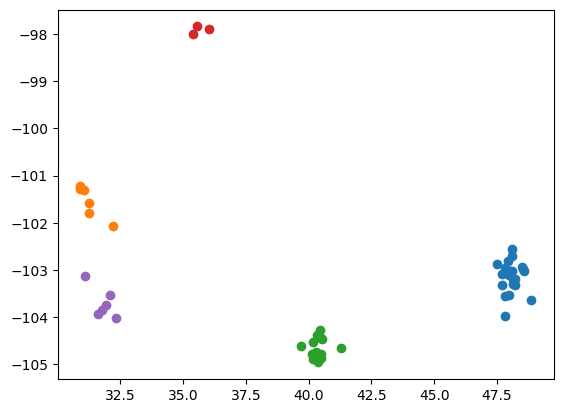

In [29]:
model = MiniBatchKMeans(n_clusters=5, n_init='auto')
show_clasters(model, data)

DBSCAN

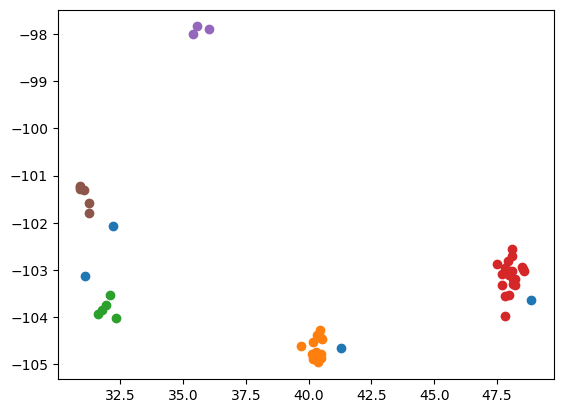

In [30]:
model = DBSCAN(eps=0.5, min_samples=2)
show_clasters(model, data)

AffinityPropagation

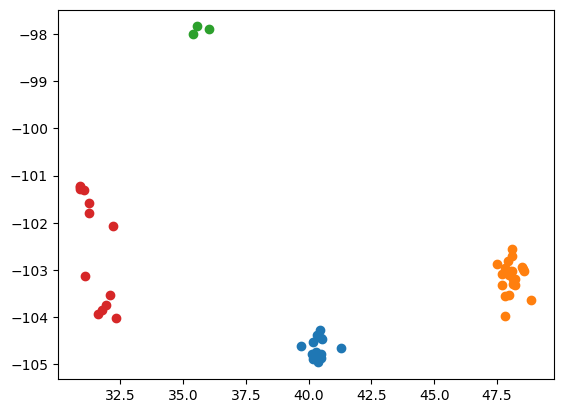

In [31]:
model = AffinityPropagation(damping=0.52)
show_clasters(model, data)

OPTICS

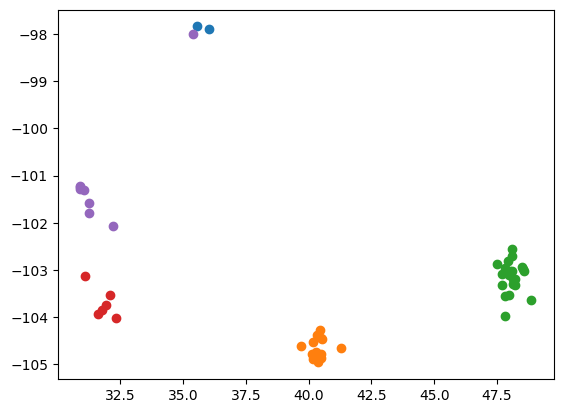

In [32]:
model = OPTICS(min_samples=0.1)
show_clasters(model, data)

AgglomerativeClustering

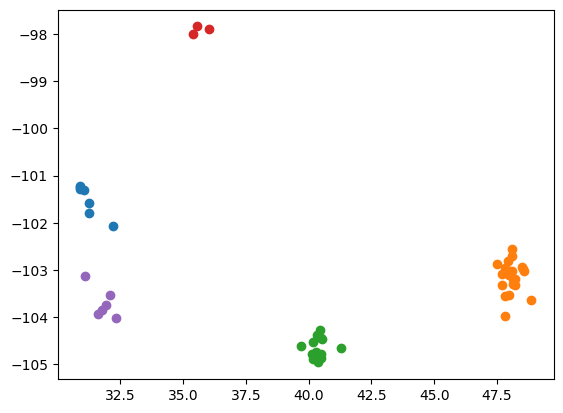

In [33]:
model = AgglomerativeClustering(n_clusters=5)
show_clasters(model, data)

SpectralClustering

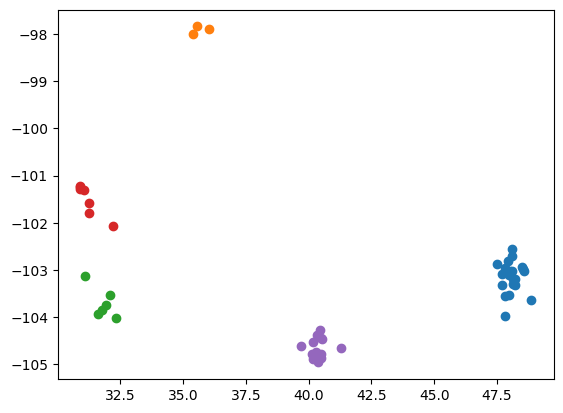

In [34]:
model = SpectralClustering(n_clusters=5)
show_clasters(model, data)

8.1 Проведите извлечение признаков из wells_info_with_prod.csv (хоть один из столбцов с датой и категориальным признаком должен остаться). Целевой переменной будет Prod1Year

In [35]:
wells_info_with_prod = pd.read_csv('data/wells_info_with_prod.csv')
wells_info_with_prod = wells_info_with_prod[['CompletionDate', 'StateName', 'Prod1Year']]
wells_info_with_prod.head()

,CompletionDate,StateName,Prod1Year
0,2014-12-02,COLORADO,126898
1,2014-02-26,COLORADO,22616
2,2014-09-07,COLORADO,47523
3,2015-03-31,COLORADO,59474
4,2014-04-23,COLORADO,14427


In [36]:
wells_info_with_prod['CompletionDate'] = pd.to_datetime(wells_info_with_prod['CompletionDate']).dt.dayofyear
states = pd.get_dummies(wells_info_with_prod['StateName'])
wells_info_with_prod = wells_info_with_prod.drop('StateName', axis=1)
data = pd.concat([wells_info_with_prod, states], axis=1)
data.head()

,CompletionDate,Prod1Year,COLORADO,NEW MEXICO,NORTH DAKOTA,OKLAHOMA,TEXAS,WYOMING
0,336,126898,1,0,0,0,0,0
1,57,22616,1,0,0,0,0,0
2,250,47523,1,0,0,0,0,0
3,90,59474,1,0,0,0,0,0
4,113,14427,1,0,0,0,0,0


In [37]:
scaled_x = scale_data(data)
scaled_x

array([[0.9241573 , 0.586844  , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.14044944, 0.04272804, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.68258427, 0.17268619, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.23314607, 0.23504336, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.29775281, 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.83146067, 0.05172342, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.62078652, 0.30560281, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.58426966, 0.15713734, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.27808989, 0.03507884, 1.        , 0.        , 0.        ,
        0.        , 0.      

4. Приведите отобранные в 8.1 задании признаки из файла wells_info_with_prod.csv в двумерное пространство. Выделите цветом добычу с этой скважины.

In [38]:
from sklearn.decomposition import PCA

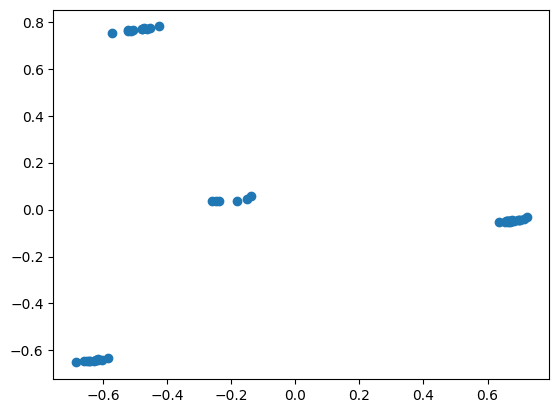

In [39]:
model = PCA(n_components=2)
squeezed = model.fit_transform(scaled_x)

plt.scatter(squeezed[:, 0], squeezed[:, 1])
plt.show()